In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.pyplot as plt

In [2]:
#ACOLLINEARITY FUNCTION
def angleacoll(th1,th2,ph1,ph2):
    v1=[np.sin(th1)*np.cos(ph1),np.sin(th1)*np.sin(ph1),np.cos(th1)]
    v2=[np.sin(th2)*np.cos(ph2),np.sin(th2)*np.sin(ph2),np.cos(th2)]
    dot = np.dot(v1,v2)
    return (abs(np.pi-np.arccos(dot)))

#function that finds number of events in dataframe
#it identifies an events by pair event number and run number
def n_events_real(df):
    sumev = 0
    for item in df.groupby(['ievt', 'irun']).size():
        sumev = sumev + item
    return sumev

def n_events_mc(dfname, df_names, nevents_nom):
    index = df_names.index(dfname)
    return nevents_nom[index]

#find corresponding cross section given the channel
def dfxsec(dfname, df_names):
    index = df_names.index(dfname)
    return xsections[index]

#find scale factor by which each channel needs to be multiplied to match data
def scalefactor(lumi, n_events, xsec):
    return (xsec*lumi)/(n_events)


def LogLR(expBkg, expSig, obs):
    #avoid log of 0 using super small number #hack
    result = obs*np.log(max(expSig+expBkg, 0.000001)) - expSig - obs*np.log(max(expBkg,0.000001))
    return -2*result

In [3]:
#initial definitions

backgrounds = ['eeqq','qq','wen','ww','zee','zz']
backgrounds_cs = [15600,102,2.90,16.5,3.35,0.975] #pb

signals = ['higgs_90','higgs_90','higgs_95']
signal_cs = [0.0940,0.0667,0.0333] #pb
data = ['data']



#concatenate all the channels
channels = backgrounds + signals + data
xsections = backgrounds_cs + signal_cs
nevents_nom = [5940000,200000,81786,294500,29500,196000,3972,3973,3971]

#list which takes into account whether the channel is a background (bkg), signal (sgn), or data (data)
bkgsigdata = []

#dataframes lists
df_names = [] #need to work with names instead of just df because python cannot find a dataframe in a list of dataframes, so i just search by name
df_list = []
df_list_cut = []

#factor *signal to make it more visible (accounted for in efficiencies)
pumpsignal = 100    

#integrate luminosity
int_lumi = 176.773 #pb^-1

In [4]:
################################
# creation of all df and lists #
################################



for channel in channels:
    #fill the dataframes
    filename = 'l3higgs189/higgs_' + channel + '.csv'
    dfname = 'df_' + channel
    vars()[dfname] = pd.read_csv(filename)
       
    #add recoiling mass against jets
    angle = 180*np.pi/180
    recmass = []
    acollin = []
    for index, row in (vars()[dfname]).iterrows():
        #acollinearity
        acollin.append(angleacoll(row['thj1'],row['thj2'],row['phj1'],row['phj2']))
            
    #(vars()[dfname])['rec_mass'] = recmass
    (vars()[dfname])['acoll'] = acollin
        
    
    
    #fill the bkgsigdata list, categorizing bkg, sgn, data
    if channel in backgrounds:
        bkgsigdata.append('bkg')
    elif channel in signals:
        bkgsigdata.append('sgn')
    elif channel in data:
        bkgsigdata.append('data')
        
    #fill dataframes lists
    df_names.append(dfname)
    df_list.append(vars()[dfname])
    

In [5]:
def midpoints_bins(bins):
    binwidth_bins = bins[1]-bins[0]
    midpointlist = []
    for item in range(0, len(bins)-1):
        midpointlist.append(bins[0] + binwidth_bins * (0.5 + item))
    return midpointlist

def binwidth_bins(bins):
    return bins[1]-bins[0]


In [6]:
#######################
# log likelihood ploz #
#######################
   
df_list_cut = []

for dfname in df_names:
    index = df_names.index(dfname)
    #tmpdf = (df_list[index])
    tmpdf = (df_list[index])[(df_list[index])['mmis'] > 70]
    tmpdf = tmpdf[tmpdf['mmis'] < 120]
    tmpdf = tmpdf[tmpdf['acthm'] < 0.8]
    tmpdf = tmpdf[tmpdf['btag1'] > 0.2]
    tmpdf = tmpdf[tmpdf['btag2'] > 0.2]

    df_list_cut.append(tmpdf)

bins = np.linspace(70,100,31)

signal90_mh = []
signal90_mh = []
signal95_mh = []
backgr_mh = [0]*(len(bins)-1)
data_mh = []

pumpsignal = 1   
nevents = [0]*len(df_list)

for dfname in df_names:
    index = df_names.index(dfname)
    
    #sum over backgrounds
    if bkgsigdata[index] == 'bkg':
        if(n_events_real(df_list_cut[index]) != 0):
            #calculate scale factor (xs) 
            scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like((df_list_cut[index])['fmvis'])
            bkg,bins_bkg,patches_bkg = plt.hist(((df_list_cut[index])['fmvis']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
            backgr_mh = np.add(backgr_mh,bkg)

    #data
    if bkgsigdata[index] == 'data':
        data_histo,bins_data,patches_data = plt.hist(((df_list_cut[index])['fmvis']), bins=bins, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

#clear all plots
plt.clf()


<Figure size 432x288 with 0 Axes>

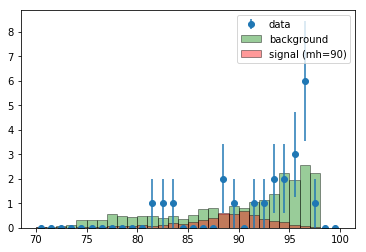

In [7]:
## CONSIDER FOR NOW 90 GEV MH HYPOTHESIS

for dfname in df_names:
    index = df_names.index(dfname)
    #signal with mh=90 GeV
    if dfname == "df_higgs_90":
        scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like((df_list_cut[index])['fmvis'])        #plot signal
        sgn_90,bins_sgn_90,patches_sgn_90 = plt.hist(((df_list_cut[index])['fmvis']), bins=bins, weights=weights, color='red', ec="black", histtype="stepfilled", label=dfname.strip("df_"), alpha=0.4)

plt.clf()


#plot data
plt.errorbar(midpoints_bins(bins), data_histo, yerr=np.sqrt(data_histo),fmt='o', label='data')
#plot background
plt.bar(midpoints_bins(bins), backgr_mh, width=binwidth_bins(bins),color='green', ec="black", label='background', alpha=0.4)
#plot signal
plt.bar(midpoints_bins(bins), sgn_90, width=binwidth_bins(bins),color='red', ec="black", label='signal (mh=90)', alpha=0.4)
plt.legend(loc="best")
plt.show()


In [8]:
#LOG LIKELIHOOD RATIO 
#-2nlQ = 2*(sum_i s_i - n_i*ln(1+s_i/b_i))

def LLR(expBkg, expSig, obs):
    result = 0
    for index in range(0,len(expBkg)):
        if expBkg[index] != 0: #ASK
        #if expBkg[index] != 0 and expSig[index]/expBkg[index]>0.05: #ASK
            result += 2*(expSig[index] - obs[index]*np.log(max((1 + expSig[index]/expBkg[index]), 0.000001)))
    return result



In [9]:
#now the different X values
print ("X(Data)=",LLR(backgr_mh,sgn_90,data_histo))
print ("X(Background)=",LLR(backgr_mh,sgn_90,backgr_mh))
print ("X(Signal 90 GeV +Background)=",LLR(backgr_mh,sgn_90,np.add(backgr_mh,sgn_90)))


('X(Data)=', 2.1058788402917075)
('X(Background)=', 1.9578695819083438)
('X(Signal 90 GeV +Background)=', -2.30597843114208)


In [10]:
def getTrials(expBkg,expSig, mean):
    return LLR(expBkg,expSig, np.random.poisson(mean) )

#By using the function above two sets of events can be created for background
#only and signal+background:

nTrials = 50000
bkgSample = []
sigPlusBkgSample = []
for i in range(0,nTrials):
    bkgSample.append(getTrials(backgr_mh,sgn_90,backgr_mh))
    sigPlusBkgSample.append(getTrials(backgr_mh,sgn_90,np.add(backgr_mh,sgn_90)))

bkg_median = np.median(bkgSample)
spb_median = np.median(sigPlusBkgSample)

print ('B-only median estimator: %.3f'%bkg_median)
print ('S+B median estimator: %.3f'%spb_median)

B-only median estimator: 2.111
S+B median estimator: -2.135


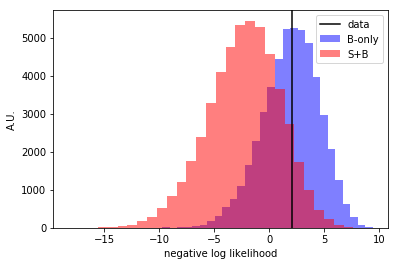

In [11]:
plt.axvline(x=LLR(backgr_mh,sgn_90,data_histo), color='black',label='data')
bkg,bins,patches = plt.hist(bkgSample,color='b', bins=30, label='B-only',alpha=0.5)
sig,bins,patches = plt.hist(sigPlusBkgSample,color='r',bins=30 ,label='S+B',alpha=0.5)
plt.xlabel('negative log likelihood')
plt.ylabel('A.U.')
plt.legend()
plt.show()

In [19]:
fracAbove=lambda trials, ref: (trials>ref).sum()/float(len(trials))

#function to calculate the 68% and 95% probability intervals centered on the bkg_median
def sigma_band_calc(trials, diff, percentage, median):
    if fracAbove(trials,median-diff)-fracAbove(trials,median+diff) > percentage+0.0001:
        return "Lower the guess"
    else:
        ev_sum = 0
        while ev_sum - percentage < 0.0001:
            diff = diff + 0.001        
            ev_sum = fracAbove(trials,median-diff)-fracAbove(trials,median+diff)

        return diff  

#calculate negative log likelihood ratio for data
dataRef=LLR(backgr_mh,sgn_90,data_histo)

#compute the CL values
CLb=fracAbove(bkgSample,dataRef)
CLsb=fracAbove(sigPlusBkgSample,dataRef)
CLs=CLsb/CLb

print ("CLb = %.4f"%CLb)
print ("CLsb = %.4f"%CLsb)
print ("CLs = %.4f"%CLs)
print ("(1-CLs) = %.4f"%(1-CLs))

#calculate and print all the sigma limits
highCLb_1sigma=fracAbove(bkgSample,bkg_median-sigma_band_calc(bkgSample,2.5,0.68,bkg_median))
lowCLb_1sigma=fracAbove(bkgSample,bkg_median+sigma_band_calc(bkgSample,2.5,0.68,bkg_median))
highCLb_2sigma=fracAbove(bkgSample,bkg_median-sigma_band_calc(bkgSample,4.5,0.95,bkg_median))
lowCLb_2sigma=fracAbove(bkgSample,bkg_median+sigma_band_calc(bkgSample,4.5,0.95,bkg_median))
highCLsb_1sigma=fracAbove(sigPlusBkgSample,bkg_median-sigma_band_calc(bkgSample,2.5,0.68,bkg_median))
lowCLsb_1sigma=fracAbove(sigPlusBkgSample,bkg_median+sigma_band_calc(bkgSample,2.5,0.68,bkg_median))
highCLsb_2sigma=fracAbove(sigPlusBkgSample,bkg_median-sigma_band_calc(bkgSample,4.5,0.95,bkg_median))
lowCLsb_2sigma=fracAbove(sigPlusBkgSample,bkg_median+sigma_band_calc(bkgSample,4.5,0.95,bkg_median))
lowCLs_1sigma=lowCLsb_1sigma/lowCLb_1sigma
highCLs_1sigma=highCLsb_1sigma/highCLb_1sigma
lowCLs_2sigma=lowCLsb_2sigma/lowCLb_2sigma
highCLs_2sigma=highCLsb_2sigma/highCLb_2sigma

print "\n\n"
print "CLb -1$\sigma$ limit =%.3f"%lowCLb_1sigma
print "CLb +1$\sigma$ limit =%.3f"%highCLb_1sigma
print "CLb -2$\sigma$ limit =%.3f"%lowCLb_2sigma
print "CLb +2$\sigma$ limit =%.3f"%highCLb_2sigma
print "CLsb -1$\sigma$ limit =%.3f"%lowCLsb_1sigma
print "CLsb +1$\sigma$ limit =%.3f"%highCLsb_1sigma
print "CLsb -2$\sigma$ limit =%.3f"%lowCLsb_2sigma
print "CLsb +2$\sigma$ limit =%.3f"%highCLsb_2sigma
print "CLs -1$\sigma$ limit =%.3f"%lowCLs_1sigma
print "CLs +1$\sigma$ limit =%.3f"%highCLs_1sigma
print "CLs -2$\sigma$ limit =%.3f"%lowCLs_2sigma
print "CLs +2$\sigma$ limit =%.3f"%highCLs_2sigma

CLb = 0.5006
CLsb = 0.0797
CLs = 0.1592
(1-CLs) = 0.8408



CLb -1$\sigma$ limit =0.145
CLb +1$\sigma$ limit =0.825
CLb -2$\sigma$ limit =0.011
CLb +2$\sigma$ limit =0.962
CLsb -1$\sigma$ limit =0.009
CLsb +1$\sigma$ limit =0.295
CLsb -2$\sigma$ limit =0.000
CLsb +2$\sigma$ limit =0.597
CLs -1$\sigma$ limit =0.059
CLs +1$\sigma$ limit =0.357
CLs -2$\sigma$ limit =0.021
CLs +2$\sigma$ limit =0.621


In [20]:
#Now caclulate the same quantitites for the expected background
CLsb=fracAbove(sigPlusBkgSample,bkg_median)
CLs=CLsb/0.5

print ("CLsb = %.4f"%CLsb)
print ("CLs = %.4f"%CLs)
print ("(1-CLs) = %.4f"%(1-CLs))

CLsb = 0.0795
CLs = 0.1589
(1-CLs) = 0.8411
